In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('C:/Users/A30010587/Downloads/cwp_interview/cwp_interview/'))
if module_path not in sys.path:
    sys.path.append(module_path)


import torch
import numpy as np
from typing import Optional, Dict, Any
import torch
import torch.nn as nn
from utils import TimeseriesDataset, NormalizationIdentity, NormalizationStandardization, _split_series_time_dims, _merge_series_time_dims, _easy_mlp, device
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cvxpy as cp
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv("Question2.csv", index_col=0, header=[0,1], parse_dates=True)

Data Import

In [ ]:
da = data["da"]
rt = data["rt"]
X = data["X"]

# example of prices with a two day lag if you wish to use timeseries as features (ie RNN, CNN, ARIMA, etc...)
shifted_da = da.shift(freq="48H")
shifted_rt = rt.shift(freq="48H")

split = datetime(2020,8,1)

X_train = X.loc[:split]
X_validate = X.loc[split:]

da_train = da.loc[:split]
da_validate = da.loc[split:]

rt_train = rt.loc[:split]
rt_validate = rt.loc[split:]

print('\nVerify NaN values')
print('X_train',X_train.isnull().values.any())
print('Nan index in X_train',X_train.isnull().values.any(1).nonzero()[0])
X_train.fillna(X_train.median(), inplace = True)
print('X_train',X_train.isnull().values.any())
print('X_validate',X_validate.isnull().values.any())
print('da_train',da_train.isnull().values.any())
print('da_validate',da_validate.isnull().values.any())
print('rt_train',rt_train.isnull().values.any())
print('rt_validate',rt_validate.isnull().values.any())


Test RNN Model

In [3]:
from Model import TradingBot
from QuantileDecoder import QuantileDecoder, AttentionalQuantile
from utils import hourly_results, worst_loss, best_loss
def RNN_model(gamma:float, l_norm:int):
    model_name = 'RNN_model'
    net = TradingBot(
        num_series=100,
        input_dim = 4,
        gamma = gamma,
        l_norm = l_norm,
        data_normalization="standardization",
        loss_normalization="series",
        rnn_decoder={
            "dim_hidden_features":2,
            "num_layers":2,#32,
            "dim_output":168 #predict one day ahead for the next week 24*7
        },
        
    )
    return net.to(device), model_name

In [ ]:

L_vals = np.arange(0.1,0.9,0.1)
L_norms = [1,2]
pd_dict={}
worst_loss_list = np.empty((len(L_norms), len(L_vals)))
worst_return_list = []
best_return_list = []
for l_norm in L_norms:
    for k, L_val in enumerate(L_vals):
        nodes = 7
        volume_short = np.zeros((len(L_vals), nodes))
        volume_long = np.zeros((len(L_vals), nodes))
        net, model_name = RNN_model(gamma= L_val, l_norm=l_norm)
        optimizer = torch.optim.RMSprop(net.parameters(), lr=1e-3, weight_decay=0)

        print(net)

        avg_loss = []

        NUM_EPOCHS = 50  # The model is very slow to train
        NUM_BATCHES = 35

        for epoch in tqdm(range(NUM_EPOCHS)):
            running_sum = 0
            for batch in range(NUM_BATCHES):
                running_sum += net.train_step(optimizer, 32, da_train.values.T, 24, 24)
            avg_loss.append(running_sum / NUM_BATCHES)

        plt.figure()
        plt.plot(avg_loss)
        plt.title('{}-Training Loss with L-{}-norm and gamma {}'.format(model_name,l_norm, round(L_val,4)))
        plt.show()

        v_long, bid, v_short, offer = net.predict(X_test, da, da_test, rt_test)
        results = hourly_results(v_long, bid.values, v_short, offer.values, da_test, rt_test)
        pnl = results.sum(axis=1).cumsum()
        pnl.plot()
        plt.title('{}-Cumulative Returns with L-{}-norm and gamma {}'.format(model_name,l_norm, round(L_val,4)))
        plt.show()
        portfolio_rets = bid.dot(v_long)+ offer.dot(v_short)
        constraint = worst_loss(results)
        best_hour = best_loss(results)
        print('Portfolio returns',np.sum(portfolio_rets))
        print('constraint',constraint)
        worst_return_list.append(constraint)
        best_return_list.append(best_hour)
        for i in range(nodes):
            volume_long[k, :] = v_long
            volume_short[k, :] = v_short
            pd_dict[l_norm, k] = pd.DataFrame({"gamma": f"{round(L_vals[k],4)}",
                            "v_shorts":v_long,
                            "v_longs":v_short})
            pd_dict[l_norm,k]['L_norm'] = f"L{l_norm}"
            
        pd_dict[l_norm,k]['model'] = model_name
        pd_dict[l_norm,k]['PTF_Return'] = np.sum(portfolio_rets)
        pd_dict[l_norm,k]['Worst_Return'] = constraint
        pd_dict[l_norm,k].loc[:, :'L_norm'].plot(kind="bar")
        plt.title("{}-L{} Norm with gamma {} and constraint {}".format(model_name,l_norm,pd_dict[l_norm,k]['gamma'][0], round(pd_dict[l_norm,k]['Worst_Return'][0],4)) )
        plt.xlabel("Nodes")
        plt.ylabel("Trades")


We pick the best startegy that satisfies our constraint and maximum the returns

The Model to consider based on vallidation dataset is : 

RNN model with gamma = 0.8 with L2-norm

In [ ]:

df_trades = pd_dict[(2,7)][['v_longs', 'v_shorts']]
df_trades
heatmap, ax = plt.subplots()
plt.imshow(df_trades, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.title('RNN-Heatmap Trades of best startegy for gamma = 0.8 and L2 norm reg.')
ax.set(xlabel='long     short', ylabel='Hub index')
plt.show()


We can visulaize the result of our startegy

In [ ]:
plt.hist(best_return_list, bins=20)
plt.hist(worst_return_list, bins=10)
plt.axvline(-1000, color='red', linestyle='solid')
plt.axvline(constraint, color='red', linestyle='dashed')
plt.legend(['Constraint = -1000',
            'Worst return',
            'Historical Returns Distribution', 
            'Returns < cVaR'])
plt.title('RNN-Historical Return and CVaR')
plt.xlabel('Return')
plt.ylabel('Observation Frequency')

Test the Transformer Model

In [8]:
from Model import TradingBot
from utils import hourly_results, worst_loss
def Transformers_model(gamma:float, l_norm:int):
    model_name = 'Transformers'
    net = TradingBot(
        num_series=100,
        input_dim = 12,
        gamma = gamma,
        l_norm = l_norm,
        data_normalization="standardization",
        loss_normalization="series",
        series_embedding_dim=13,
        input_encoder_layers=3,
        input_encoding_normalization=True,
        encoder= {
            "attention_layers":3,
            "attention_heads": 3,
            "attention_dim": 4,
            "attention_feedforward_dim": 12,
        },
        quantile_decoder={
             "min_u": 0.01,
             "max_u": 0.99,
            "attentional_quantile": {
                "attention_heads": 3,
                "attention_layers": 3,
                "attention_dim": 12,
                "mlp_layers": 3,
                "mlp_dim": 16,
                "resolution": 50,
            },
        }
    )
    return net.to(device), model_name

In [ ]:

L_vals = np.arange(0.1,0.9,0.1)
L_norms = [1,2]
pd_dict={}
worst_loss_list = np.empty((len(L_norms), len(L_vals)))
worst_return_list = []
best_return_list = []
for l_norm in L_norms:
    for k, L_val in enumerate(L_vals):
        nodes = 7
        volume_short = np.zeros((len(L_vals), nodes))
        volume_long = np.zeros((len(L_vals), nodes))
        net, model_name = Transformers_model(gamma= L_val, l_norm=l_norm)
        optimizer = torch.optim.RMSprop(net.parameters(), lr=1e-3, weight_decay=0)

        print(net)

        avg_loss = []

        NUM_EPOCHS = 50  # The model is very slow to train
        NUM_BATCHES = 35

        for epoch in tqdm(range(NUM_EPOCHS)):
            running_sum = 0
            for batch in range(NUM_BATCHES):
                running_sum += net.train_step(optimizer, 32, da_train.values.T, 24, 24)
            avg_loss.append(running_sum / NUM_BATCHES)

        plt.figure()
        plt.plot(avg_loss)
        plt.title('{}-Training Loss with L-{}-norm and gamma {}'.format(model_name,l_norm, round(L_val,4)))
        plt.show()

        v_long, bid, v_short, offer = net.predict(X_test, da, da_test, rt_test)
        results = hourly_results(v_long, bid.values, v_short, offer.values, da_test, rt_test)
        pnl = results.sum(axis=1).cumsum()
        pnl.plot()
        plt.title('{}-Cumulative Returns with L-{}-norm and gamma {}'.format(model_name,l_norm, round(L_val,4)))
        plt.show()
        portfolio_rets = bid.dot(v_long)+ offer.dot(v_short)
        constraint = worst_loss(results)
        best_hour = best_loss(results)
        print('Portfolio returns',np.sum(portfolio_rets))
        print('constraint',constraint)
        worst_return_list.append(constraint)
        best_return_list.append(best_hour)
        for i in range(nodes):
            volume_long[k, :] = v_long
            volume_short[k, :] = v_short
            pd_dict[l_norm, k] = pd.DataFrame({"gamma": f"{round(L_vals[k],4)}",
                            "v_shorts":v_long,
                            "v_longs":v_short})
            pd_dict[l_norm,k]['L_norm'] = f"L{l_norm}"
            
        pd_dict[l_norm,k]['model'] = model_name
        pd_dict[l_norm,k]['PTF_Return'] = np.sum(portfolio_rets)
        pd_dict[l_norm,k]['Worst_Return'] = constraint
        pd_dict[l_norm,k].loc[:, :'L_norm'].plot(kind="bar")
        plt.title("{}-L{} Norm with gamma {} and constraint {}".format(model_name,l_norm,pd_dict[l_norm,k]['gamma'][0], round(pd_dict[l_norm,k]['Worst_Return'][0],4)) )
        plt.xlabel("Nodes")
        plt.ylabel("Trades")


We pick the best startegy that satisfies our constraint and maximum the returns

The Model to consider based on vallidation dataset is : 

Transformer model with gamma = 0.8 with L2-norm

In [ ]:

df_trades = pd_dict[(2,7)][['v_longs', 'v_shorts']]
df_trades
heatmap, ax = plt.subplots()
plt.imshow(df_trades, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.title('Transformers-Heatmap Trades of best startegy for gamma = 0.8 and L2 norm reg.')
ax.set(xlabel='long     short', ylabel='Hub index')
plt.show()


We can visualize our startegy below

Text(0, 0.5, 'Observation Frequency')

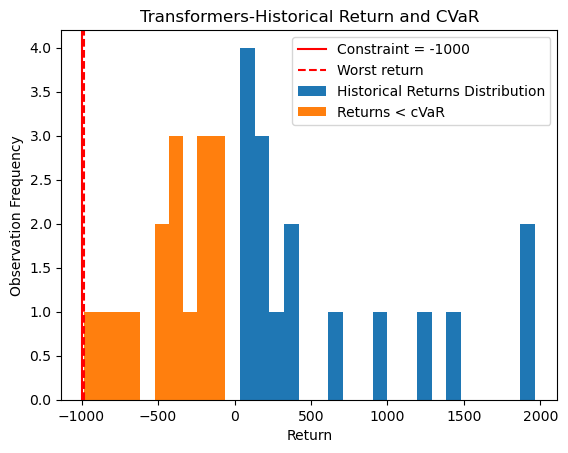

In [14]:

plt.hist(best_return_list, bins=20)
plt.hist(worst_return_list, bins=10)
plt.axvline(-1000, color='red', linestyle='solid')
plt.axvline(constraint, color='red', linestyle='dashed')
plt.legend(['Constraint = -1000',
            'Worst return',
            'Historical Returns Distribution', 
            'Returns < cVaR'])
plt.title('Transformers-Historical Return and CVaR')
plt.xlabel('Return')
plt.ylabel('Observation Frequency')